(6000, 3, 32, 32) float32
(6000,) int64
(300, 3, 32, 32) float32


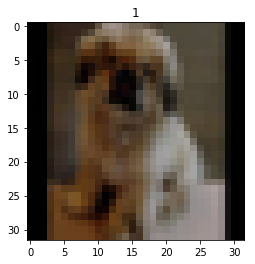

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

with np.load('prediction-challenge-02-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2. INDEX: COLOR CHANNELS (3)
# 3/4. INDEX: PIXEL VALUE (32 x 32)
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

plt.imshow(data_x[4999].transpose((1,2,0)))
plt.title(data_y[4999])
plt.show()

In [2]:
data_y

array([1, 0, 1, ..., 2, 0, 1])

In [3]:
np.histogram(data_y[:500],bins=[0,1,2,3])

(array([164, 183, 153]), array([0, 1, 2, 3]))

In [4]:
np.histogram(data_y[500:],bins=[0,1,2,3])

(array([1836, 1817, 1847]), array([0, 1, 2, 3]))

In [5]:
(data_x[2]*255).astype('uint8')

array([[[ 22,  39,  48, ...,  61,  49,  28],
        [ 24,  45,  58, ...,  74,  46,  25],
        [ 41,  64,  69, ...,  92,  48,  36],
        ..., 
        [136, 129, 153, ...,  95,  96,  91],
        [140, 127, 137, ..., 120, 118,  96],
        [128, 126, 126, ..., 124, 126,  61]],

       [[110, 118, 119, ..., 126, 123, 113],
        [109, 114, 115, ..., 123, 111, 101],
        [114, 114, 106, ..., 125, 105, 103],
        ..., 
        [ 96,  90, 120, ...,  76,  78,  72],
        [100,  88, 105, ...,  98,  98,  78],
        [ 87,  86,  93, ...,  99, 104,  44]],

       [[200, 200, 193, ..., 193, 193, 205],
        [194, 187, 182, ..., 177, 176, 184],
        [188, 170, 157, ..., 163, 164, 176],
        ..., 
        [ 60,  54,  83, ...,  62,  68,  67],
        [ 67,  54,  67, ...,  78,  82,  68],
        [ 58,  54,  54, ...,  72,  83,  31]]], dtype=uint8)

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.set_num_threads(8)
torch.get_num_threads() 

1

In [7]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

stochastic_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.RandomRotation(15),
     transforms.RandomHorizontalFlip(),
     torchvision.transforms.ColorJitter(brightness=0.15,contrast=0.8,hue=0.1,saturation=0.8),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


In [8]:
class CIFARdataset(torch.utils.data.Dataset):
    def __init__(self, fp, transform, dset="train"):
        VAL_SIZE = 500
        self.transform = transform
        with np.load(fp) as fh:
            if dset=="train":
                self.data_x = (fh['data_x'][VAL_SIZE:]*255).astype('uint8')
                self.data_y = fh['data_y'][VAL_SIZE:]
                assert len(self.data_x) == len(self.data_y)
            elif dset=="test":
                self.data_x = (fh['data_x'][:VAL_SIZE]*255).astype('uint8')
                self.data_y = fh['data_y'][:VAL_SIZE]
                assert len(self.data_x) == len(self.data_y)
            elif dset=="pred":
                self.data_x = (fh['test_x']*255).astype('uint8')
                self.data_y = None

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, i):
        image = self.data_x[i].transpose(1,2,0)
        if self.data_y is None:
            image = self.transform(image)
            return image
        label = self.data_y[i]
        if self.transform:
            image = self.transform(image)
        sample = (image, label)
        return sample

In [9]:
fp = 'prediction-challenge-02-data.npz'
train_dataset = CIFARdataset(fp,stochastic_transform,dset="train")
test_dataset = CIFARdataset(fp,transform,dset="test")
pred_dataset = CIFARdataset(fp,transform,dset="pred")

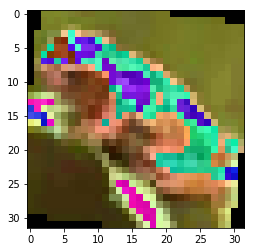

In [10]:
x = train_dataset[0][0].numpy()
plt.imshow(x.transpose((1,2,0)))
plt.show()

In [11]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=8, 
                                           shuffle=True,
                                           **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False,
                                          **kwargs)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.conv4(x))
        x = self.pool(x)
      
        
        x = x.view(-1, 32 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 3 * 3, 42)
        self.fc2 = nn.Linear(42, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        #print(x.size())
      
        
        x = x.view(-1, 32 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 1 * 1, 24)
        self.fc2 = nn.Linear(24, 3)
        
        self.pool = nn.MaxPool2d(3, 3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        #print(x.size())
      
        
        x = x.view(-1, 64 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net1 = Net()

net2 = Net2()

net3 = Net3()

In [13]:
from torch.autograd import Variable

def train(model,optimizer,epoch):
    model.train()
    
    for batch_idx, (data,target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        
        optimizer.zero_grad()
        
        output = model(data)

        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))     
            
def evaluate(model,optimizer):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            output = model(data)
            
            val_loss += nn.CrossEntropyLoss(size_average=False)(output, target).item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        val_loss /= len(test_loader.dataset)
        print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

In [14]:
import torch.optim as optim

# criterion_train = nn.CrossEntropyLoss()
# criterion_test = nn.CrossEntropyLoss(size_average=False)
optimizer1 = optim.Adam(net1.parameters()) #SGD(model.parameters(), lr=0.008, momentum=0.9)

In [106]:
epochs = 30
for epoch in range(1, epochs + 1):
    train(net1,optimizer1, epoch)
    evaluate(net1,optimizer1)

Train Epoch: 1 [0/5500 (0%)]	Loss: 0.120953
Train Epoch: 1 [1600/5500 (29%)]	Loss: 0.608870
Train Epoch: 1 [3200/5500 (58%)]	Loss: 0.185919
Train Epoch: 1 [4800/5500 (87%)]	Loss: 0.656778
Validation set: Average loss: 0.5305, Accuracy: 380/500 (76%)

Train Epoch: 2 [0/5500 (0%)]	Loss: 0.290907
Train Epoch: 2 [1600/5500 (29%)]	Loss: 0.616487
Train Epoch: 2 [3200/5500 (58%)]	Loss: 1.499288
Train Epoch: 2 [4800/5500 (87%)]	Loss: 0.489130
Validation set: Average loss: 0.6902, Accuracy: 367/500 (73%)

Train Epoch: 3 [0/5500 (0%)]	Loss: 0.459042
Train Epoch: 3 [1600/5500 (29%)]	Loss: 0.580483
Train Epoch: 3 [3200/5500 (58%)]	Loss: 0.590616
Train Epoch: 3 [4800/5500 (87%)]	Loss: 0.428472
Validation set: Average loss: 0.5710, Accuracy: 374/500 (74%)

Train Epoch: 4 [0/5500 (0%)]	Loss: 0.304985
Train Epoch: 4 [1600/5500 (29%)]	Loss: 0.446098
Train Epoch: 4 [3200/5500 (58%)]	Loss: 0.744040
Train Epoch: 4 [4800/5500 (87%)]	Loss: 0.451343
Validation set: Average loss: 0.5604, Accuracy: 380/500 (76

In [16]:
optimizer2 = optim.Adam(net2.parameters())

In [17]:
epochs = 30
for epoch in range(1, epochs + 1):
    train(net2,optimizer2,epoch)
    evaluate(net2,optimizer2)

Train Epoch: 1 [0/5500 (0%)]	Loss: 1.105009
Train Epoch: 1 [1600/5500 (29%)]	Loss: 1.178339
Train Epoch: 1 [3200/5500 (58%)]	Loss: 0.813777
Train Epoch: 1 [4800/5500 (87%)]	Loss: 0.701552
Validation set: Average loss: 0.8881, Accuracy: 284/500 (56%)

Train Epoch: 2 [0/5500 (0%)]	Loss: 1.147110
Train Epoch: 2 [1600/5500 (29%)]	Loss: 0.937995
Train Epoch: 2 [3200/5500 (58%)]	Loss: 1.047457
Train Epoch: 2 [4800/5500 (87%)]	Loss: 0.595281
Validation set: Average loss: 0.8486, Accuracy: 298/500 (59%)

Train Epoch: 3 [0/5500 (0%)]	Loss: 0.646806
Train Epoch: 3 [1600/5500 (29%)]	Loss: 0.666661
Train Epoch: 3 [3200/5500 (58%)]	Loss: 0.729717
Train Epoch: 3 [4800/5500 (87%)]	Loss: 0.636446
Validation set: Average loss: 0.7918, Accuracy: 299/500 (59%)

Train Epoch: 4 [0/5500 (0%)]	Loss: 0.872458
Train Epoch: 4 [1600/5500 (29%)]	Loss: 0.841664
Train Epoch: 4 [3200/5500 (58%)]	Loss: 0.538523
Train Epoch: 4 [4800/5500 (87%)]	Loss: 0.580528
Validation set: Average loss: 0.7157, Accuracy: 315/500 (63

In [18]:
optimizer3 = optim.Adam(net3.parameters())

In [19]:
epochs = 30
for epoch in range(1, epochs + 1):
    train(net3,optimizer3,epoch)
    evaluate(net3,optimizer3)

Train Epoch: 1 [0/5500 (0%)]	Loss: 1.141929
Train Epoch: 1 [1600/5500 (29%)]	Loss: 1.003438
Train Epoch: 1 [3200/5500 (58%)]	Loss: 0.996973
Train Epoch: 1 [4800/5500 (87%)]	Loss: 1.109048
Validation set: Average loss: 0.9752, Accuracy: 250/500 (50%)

Train Epoch: 2 [0/5500 (0%)]	Loss: 1.082916
Train Epoch: 2 [1600/5500 (29%)]	Loss: 0.847367
Train Epoch: 2 [3200/5500 (58%)]	Loss: 1.003161
Train Epoch: 2 [4800/5500 (87%)]	Loss: 0.907822
Validation set: Average loss: 0.8675, Accuracy: 277/500 (55%)

Train Epoch: 3 [0/5500 (0%)]	Loss: 0.571546
Train Epoch: 3 [1600/5500 (29%)]	Loss: 0.704206
Train Epoch: 3 [3200/5500 (58%)]	Loss: 0.779573
Train Epoch: 3 [4800/5500 (87%)]	Loss: 1.065282
Validation set: Average loss: 0.8363, Accuracy: 308/500 (61%)

Train Epoch: 4 [0/5500 (0%)]	Loss: 0.793424
Train Epoch: 4 [1600/5500 (29%)]	Loss: 0.709719
Train Epoch: 4 [3200/5500 (58%)]	Loss: 0.694833
Train Epoch: 4 [4800/5500 (87%)]	Loss: 1.018618
Validation set: Average loss: 0.7730, Accuracy: 315/500 (63

In [93]:
def pred(pred_dataset,model):
    pred_loader = torch.utils.data.DataLoader(pred_dataset,
                                          batch_size=8,
                                          shuffle=False,
                                          **kwargs)
    model.eval()
    result = np.zeros((len(pred_dataset)))
    with torch.no_grad():
        for i, data in enumerate(pred_loader):
            batch_size = data.size()[0]
            data = Variable(data)
            output = model(data)
            pred_class = output.data.max(1, keepdim=False)[1] # get the index of the max log-probability
            #print(pred_class)
            result[(i*8):(i*8)+batch_size] = pred_class
    return result

In [104]:
prediction = pred(pred_dataset,net1)
np.histogram(prediction,bins=[0,1,2,3])

(array([ 86, 117,  97]), array([0, 1, 2, 3]))

In [105]:
# PREDICT prediction FROM test_x

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
assert prediction.ndim == 1
assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
np.save('prediction.npy', prediction)